In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None # affiche toutes les colonnes lors de l'affichage des DataFrames
pd.options.display.float_format = '{:.2f}'.format # affiche les nombres à virgule flottante avec 2 décimales

In [2]:
df_raw = pd.read_csv(
    "../data/1-raw/slo_annuel_2024.csv", 
    dtype={
        "id_circ": "string",
        "num_marche": "string",
        "code_ci_origine": "string",
        "code_ch_origine": "string",
        "lib_ci_origine": "string",
        "code_ci_destination": "string",
        "code_ch_destination": "string",
        "lib_ci_destination": "string",
        "ui": "string",
        "lib_ui": "string",
        "tct": "string",
        "lib_tct": "string",
        "rang" : "Int64",
        "code_ci_jalon": "string",
        "code_ch_jalon": "string",
        "lib_ci_jalon": "string",
        "code_ligne" : "string",
        "pk": "string",
        "distance_cumul" : "Int64",
        "type_horaire": "string",
        "id_engin": "string",
        "composition": "string",
        "mode_traction": "string"
    },
    parse_dates=[
        "date_circ",
        "dh_the_jalon",
        "dh_obs_jalon",
        "dh_est_jalon"
        ]
    )

# copie

In [3]:
df = df_raw.copy()
df.shape

(1873489, 27)

# compréhension des données

In [4]:
df.head(3)

,date_circ,id_circ,num_marche,code_ci_origine,code_ch_origine,lib_ci_origine,code_ci_destination,code_ch_destination,lib_ci_destination,ui,lib_ui,tct,lib_tct,rang,code_ci_jalon,code_ch_jalon,lib_ci_jalon,code_ligne,pk,distance_cumul,type_horaire,dh_the_jalon,dh_obs_jalon,dh_est_jalon,id_engin,composition,mode_traction
0,2024-01-01,82524375,9730,751008,BV,Marseille-St-Charles,784009,ES,Perpignan,9156,RENFE VIAJEROS,LVJ,"TAGV International France-Espagne, à charge",0,751008,BV,Marseille-St-Charles,830000,862+050,0,D,2024-01-01 08:04:00,2024-01-01 08:04:48,2024-01-01 08:04:48,TGVR,E32C,E
1,2024-01-01,82519044,4071,547000,BV,Paris-Austerlitz,481002,BV,Nantes,9159,OSLO,NB1,"GL Inter-Villes - Train classique, VL>= 160 km/h",0,547000,BV,Paris-Austerlitz,570000,0+000,0,D,2024-01-01 07:12:00,2024-01-01 07:16:38,2024-01-01 07:16:38,22200,V160,E
2,2024-01-01,82519044,4071,547000,BV,Paris-Austerlitz,481002,BV,Nantes,9159,OSLO,NB1,"GL Inter-Villes - Train classique, VL>= 160 km/h",61,545244,BV,Juvisy,570000,19+038,19028,A,2024-01-01 07:25:00,2024-01-01 07:30:15,2024-01-01 07:30:15,22200,V160,E


In [5]:
# premier constat : il y a énormément de redondance dans les données, car les infos de chaque train (id_circ, date_circ, code_ci_origine, lib_ci_origine, etc) sont répétées pour chaque point de passage du train... alors qu'ils ne changent pas.
# une meilleure organisation serait de séparer les informations statiques du train des informations dynamiques liées aux points de passage, dans deux tables distinctes.
# pour simplifier l'analyse, on ne gardera dans un premier temps que le départ et l'arrivée, en agrégant les données sur une seule ligne par trajet (id_circ).

In [6]:
# df.describe(include='all')

In [7]:
df['id_circ'].nunique()
# 260067 circulations (trains) distinctes

260067

In [8]:
df['num_marche'].nunique()
# pour seulement 2771 trajets différents (numéro de marche)

2771

In [9]:
df['lib_ui'].value_counts()

lib_ui
SNCF-VOYAGES           1720054
THI FACTORY              78863
OSLO                     37328
RENFE VIAJEROS           17135
TRENITALIA FRANCE        15174
SNCF-VOYAGEURS            3485
SNCF VOYAGES ITALIA       1450
Name: count, dtype: Int64

In [10]:
df['lib_tct'].value_counts()

lib_tct
TAGV - Sud-Est, à charge                                                      464679
TAGV - Atlantique, à charge                                                   356342
TAGV - Nord, à charge                                                         236444
TAGV - Est, à charge                                                          229227
TAGV, axe Bretagne, à charge                                                  113447
TAGV (Train A Grande Vitesse - à charge)                                       91141
TAGV International France Suisse, à charge                                     75920
TAGV haute capacité Nord, à charge                                             62700
TAGV haute capacité Sud-Est, à charge                                          53196
TAGV haute capacité Atlantique, à charge                                       48159
TAGV International France Allemagne, à charge                                  43105
GL Inter-Villes - Train classique, VL>= 160 km/h         

In [11]:
df['mode_traction'].value_counts()

mode_traction
E    1866864
T       2572
B          2
Name: count, dtype: Int64

In [12]:
df.isna().sum()

date_circ                  0
id_circ                    0
num_marche                 0
code_ci_origine            0
code_ch_origine            0
lib_ci_origine           171
code_ci_destination        0
code_ch_destination        0
lib_ci_destination       189
ui                         0
lib_ui                     0
tct                        0
lib_tct                    0
rang                       0
code_ci_jalon              0
code_ch_jalon              0
lib_ci_jalon           14388
code_ligne                41
pk                        41
distance_cumul             0
type_horaire               0
dh_the_jalon           44341
dh_obs_jalon           44359
dh_est_jalon              41
id_engin                3989
composition             4030
mode_traction           4051
dtype: int64

In [13]:
# df[df.duplicated()]
# aucun doublon, super

# Nettoyage des données

In [14]:
"""# conversion des dates -> réalisé dès l'ingestion
df['date_circ'] = pd.to_datetime(df['date_circ'], errors='coerce', format='%Y-%m-%d')
df['dh_the_jalon'] = pd.to_datetime(df['dh_the_jalon'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
df['dh_obs_jalon'] = pd.to_datetime(df['dh_obs_jalon'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
df['dh_est_jalon'] = pd.to_datetime(df['dh_est_jalon'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
df.shape"""

"# conversion des dates -> réalisé dès l'ingestion\ndf['date_circ'] = pd.to_datetime(df['date_circ'], errors='coerce', format='%Y-%m-%d')\ndf['dh_the_jalon'] = pd.to_datetime(df['dh_the_jalon'], errors='coerce', format='%Y-%m-%d %H:%M:%S')\ndf['dh_obs_jalon'] = pd.to_datetime(df['dh_obs_jalon'], errors='coerce', format='%Y-%m-%d %H:%M:%S')\ndf['dh_est_jalon'] = pd.to_datetime(df['dh_est_jalon'], errors='coerce', format='%Y-%m-%d %H:%M:%S')\ndf.shape"

In [15]:
"""# Homogénéisation des colonnes d'identifiants -> réalisé dès l'ingestion
df['id_circ'] = df['id_circ'].astype("string")
df['num_marche'] = df['num_marche'].astype("string")
df['code_ci_origine'] = df['code_ci_origine'].astype("string")
df["code_ch_origine"] = df['code_ch_origine'].astype("string")
df['code_ci_destination'] = df['code_ci_destination'].astype("string")
df['code_ci_jalon'] = df['code_ci_jalon'].astype("string")
df['lib_ci_destination'] = df['lib_ci_destination'].astype("string")
""" 

'# Homogénéisation des colonnes d\'identifiants -> réalisé dès l\'ingestion\ndf[\'id_circ\'] = df[\'id_circ\'].astype("string")\ndf[\'num_marche\'] = df[\'num_marche\'].astype("string")\ndf[\'code_ci_origine\'] = df[\'code_ci_origine\'].astype("string")\ndf["code_ch_origine"] = df[\'code_ch_origine\'].astype("string")\ndf[\'code_ci_destination\'] = df[\'code_ci_destination\'].astype("string")\ndf[\'code_ci_jalon\'] = df[\'code_ci_jalon\'].astype("string")\ndf[\'lib_ci_destination\'] = df[\'lib_ci_destination\'].astype("string")\n'

In [16]:
# compte les types dans une colonne donnée
# df['lib_ci_destination'].map(type).value_counts()

In [17]:
# affiche les lignes où le type est float
# df[df['lib_ci_destination'].map(type) != str]

In [18]:
df.shape

(1873489, 27)

In [19]:
df[df['dh_the_jalon'].isna() | df['dh_obs_jalon'].isna() | df['dh_est_jalon'].isna()].shape 
# constat : 88739 lignes sur 1873489, soit 4.7% de lignes avec une ou plusieurs dates manquantes
# en réalité, si dh_obs_jalon est manquant, on peut compenser par dh_est_jalon.

(88739, 27)

In [20]:
# lignes avec date observée ET estimée manquante : aucune, super !
df[df['dh_obs_jalon'].isna() & df['dh_est_jalon'].isna()].shape

(0, 27)

In [21]:
# lignes avec date théorique ou estimée manquante : difficilement récupérable...
df[df['dh_the_jalon'].isna() | df['dh_est_jalon'].isna()].shape
# 44380 sur 1873489, soit 2.3% de lignes concernées.

(44380, 27)

In [22]:
# TODO : faire un test. dupliquer le notebook, supprimer les lignes incomplètes, et voir si on perd des données à l'arrivée ou pas.
# df = df.dropna(subset=['dh_the_jalon', 'dh_est_jalon'])
# df.shape

# Pivot : pour garder une seule ligne par trajet

In [23]:
# on flag le départ et l'arrivée : 
# code_ci_jalon == code_ci_origine & type_horaire = 'D' ou 'P' ou 'I' -> départ 
# code_ci_jalon == code_ci_destination & type_horaire = 'A' ou 'P' ou 'I' -> arrivée 
# ('D' : départ, 'A' : arrivée, 'P' : passage)
# ('I' : non documenté, concerne très peu de lignes. gare intermédiaire, peut-être ?)
# En situation pro, il aurait fallu enquêter là dessus pour s'assurer que mes filtres sont pertinents.
df['is_depart'] = (df['code_ci_jalon'] == df['code_ci_origine']) & (df['type_horaire'].isin(['D', 'P', 'I']))
df['is_arrivee'] = (df['code_ci_jalon'] == df['code_ci_destination']) & (df['type_horaire'].isin(['A', 'P', 'I']))
df.shape

(1873489, 29)

In [24]:
# on garde UNIQUEMENT les lignes de DEPART et d'ARRIVEE
df_trajets = df[df['is_depart'] | df['is_arrivee']].copy()
df_trajets.shape

(516403, 29)

In [25]:
# trajets qui ont is_depart et is_arrivee true en même temps ?
df_trajets[df_trajets['is_depart'] & df_trajets['is_arrivee']]
# il y a 74 lignes, n'apporte aucune info pertinente (trajet Modane -> Modane par exemple)
df_trajets = df_trajets[~(df_trajets['is_depart'] & df_trajets['is_arrivee'])]

In [26]:
df_trajets['is_depart'].value_counts()

is_depart
False    258508
True     257821
Name: count, dtype: Int64

In [27]:
df_trajets['is_arrivee'].value_counts()

is_arrivee
True     258508
False    257821
Name: count, dtype: Int64

In [28]:
# remplace is_depart et is_arrivee par une seule colonne : type_arret
df_trajets['type_arret'] = np.where(df_trajets['is_depart'], 'depart', 'arrivee') # on peut faire ça car on a déjà filtré les lignes où les deux sont true
df_trajets = df_trajets.drop(columns=['is_depart', 'is_arrivee'])
df_trajets['type_arret'].value_counts()

type_arret
arrivee    258508
depart     257821
Name: count, dtype: int64

In [29]:
# df_trajets[df_trajets['id_circ'] == '82520670']
# constat : LIB_TCT peut changer en cours de route (exemple : TAGV Atlantique -> TAGV Bretagne).
# à passer en valeur agrégée dans le pivot plus bas.

In [30]:
df_trajets[df_trajets['id_circ'] == '84942965']
# constat : ID_ENGIN peut changer en cours de route, dans de très rares cas (56 lignes, donc 28 trajets).
# à passer en valeur agrégée dans le pivot plus bas.

,date_circ,id_circ,num_marche,code_ci_origine,code_ch_origine,lib_ci_origine,code_ci_destination,code_ch_destination,lib_ci_destination,ui,lib_ui,tct,lib_tct,rang,code_ci_jalon,code_ch_jalon,lib_ci_jalon,code_ligne,pk,distance_cumul,type_horaire,dh_the_jalon,dh_obs_jalon,dh_est_jalon,id_engin,composition,mode_traction,type_arret
1223102,2024-05-04,84942965,9706,784009,ES,Perpignan,686006,BV,Paris-Gare-de-Lyon,1187,SNCF-VOYAGES,NVJ,"TAGV International France Espagne, à charge",15,784009,BV,Perpignan,677000,467+512,7162,D,2024-05-04 17:55:00,2024-05-04 17:54:49,2024-05-04 17:54:49,TGV2N2,E32C,E,depart
1223116,2024-05-04,84942965,9706,784009,ES,Perpignan,686006,BV,Paris-Gare-de-Lyon,1187,SNCF-VOYAGES,NVJ,"TAGV International France Espagne, à charge",315,686006,BV,Paris-Gare-de-Lyon,830000,0+000,907489,A,2024-05-04 23:18:00,2024-05-04 23:22:16,2024-05-04 23:22:16,TGV-D,E32C,E,arrivee


In [31]:
# on vérifie qu'il n'y a aucun doublon pour la clef utilisée dans le pivot plus bas
df_trajets[df_trajets.duplicated(subset=['id_circ', 'date_circ', 'num_marche', 'code_ci_origine', 'lib_ci_origine', 
                                         'code_ci_destination', 'lib_ci_destination', 'lib_ui', 'id_engin', 'type_arret'], keep=False)].head(3)

,date_circ,id_circ,num_marche,code_ci_origine,code_ch_origine,lib_ci_origine,code_ci_destination,code_ch_destination,lib_ci_destination,ui,lib_ui,tct,lib_tct,rang,code_ci_jalon,code_ch_jalon,lib_ci_jalon,code_ligne,pk,distance_cumul,type_horaire,dh_the_jalon,dh_obs_jalon,dh_est_jalon,id_engin,composition,mode_traction,type_arret
2155,2024-01-16,82841957,9743,775007,BV,Nîmes,784009,ES,Perpignan,9156,RENFE VIAJEROS,LVJ,"TAGV International France-Espagne, à charge",0,775007,BV,Nîmes,810000,27+150,0,D,2024-01-16 15:55:00,2024-01-16 19:49:00,2024-01-16 19:49:00,TGVR,E32C,E,depart
2156,2024-01-16,82841957,9743,775007,BV,Nîmes,784009,ES,Perpignan,9156,RENFE VIAJEROS,LVJ,"TAGV International France-Espagne, à charge",1,775007,BV,Nîmes,810000,27+150,0,D,2024-01-16 15:59:00,NaT,2024-01-16 19:50:33,TGVR,E32C,E,depart
6237,2024-01-03,82559757,9264,713040,BV,Dijon-Ville,686006,BV,Paris-Gare-de-Lyon,1187,SNCF-VOYAGES,LVH,"TAGV International France Suisse, à charge",0,713040,BV,Dijon-Ville,830000,314+208,0,D,2024-01-03 09:26:00,2024-01-03 09:30:00,2024-01-03 09:30:00,TGV2N2,E32C,E,depart


In [32]:
# constat : 2451 trajets avec des départs ou arrivées en double.
# Idéalement, on devrait enquêter pour comprendre la raison derrière. 
# Ici, on constate que pour à peu près une ligne sur deux, il manque des dates (théorique, observée ou estimée).
# On va donc garder les lignes avec le plus d'informations (non nulles) sur les dates :
df_trajets['num_dates_non_nulles'] = df_trajets[['dh_the_jalon', 'dh_obs_jalon', 'dh_est_jalon']].notna().sum(axis=1) # compte le nombre de dates non nulles par ligne
df_trajets = df_trajets.sort_values(by=['id_circ','type_arret', 'num_dates_non_nulles'], ascending=[True, True, False])
df_trajets = df_trajets.drop_duplicates(subset=['id_circ', 'date_circ', 'num_marche', 'code_ci_origine', 'lib_ci_origine', 
            'code_ci_destination', 'lib_ci_destination', 'lib_ui', 'id_engin', 'type_arret'], keep='first') # garde la ligne avec le plus de dates non nulles

In [33]:
# vérification qu'il n'y a plus aucun doublon
df_trajets[df_trajets.duplicated(subset=['id_circ', 'date_circ', 'num_marche', 'code_ci_origine', 'lib_ci_origine', 
            'code_ci_destination', 'lib_ci_destination', 'lib_ui', 'id_engin', 'type_arret'], keep=False)]

,date_circ,id_circ,num_marche,code_ci_origine,code_ch_origine,lib_ci_origine,code_ci_destination,code_ch_destination,lib_ci_destination,ui,lib_ui,tct,lib_tct,rang,code_ci_jalon,code_ch_jalon,lib_ci_jalon,code_ligne,pk,distance_cumul,type_horaire,dh_the_jalon,dh_obs_jalon,dh_est_jalon,id_engin,composition,mode_traction,type_arret,num_dates_non_nulles


In [34]:
# compte le nombre de types d'arrêt par id_circ (il en faut 1 ou 2 : départ et arrivée)
df_trajets.groupby('id_circ')['type_arret'].nunique().value_counts()
# constat : on a 4565 trajets sur 255267 pour lesquels il manque le départ ou l'arrivée, soit 1.8%. supprimé plus loin, après le pivot.

type_arret
2    255267
1      4565
Name: count, dtype: int64

In [35]:
### PIVOT : pour avoir UNE LIGNE PAR TRAJET
df_trajets_pivot = df_trajets.pivot_table(
    index = ['id_circ', 'date_circ', 'num_marche', 'code_ci_origine', 'lib_ci_origine', 
            'code_ci_destination', 'lib_ci_destination', 'lib_ui'],
    columns = ['type_arret'],
    values = ['dh_the_jalon', 'dh_est_jalon', 'dh_obs_jalon', 'distance_cumul', 'lib_tct', 'id_engin'],
    aggfunc = 'first'  # on a déjà géré les doublons, donc ce paramètre ne devrait avoir aucun impact.
)

# on aplatit les colonnes multi-index
df_trajets_pivot.columns = ['_'.join(col).strip() for col in df_trajets_pivot.columns.values]
df_trajets_pivot = df_trajets_pivot.reset_index()

# on renomme les colonnes
df_trajets_pivot = df_trajets_pivot.rename(columns={
    'dh_the_jalon_depart': 'depart_theorique',
    'dh_the_jalon_arrivee': 'arrivee_theorique',
    'dh_est_jalon_depart': 'depart_estime',
    'dh_est_jalon_arrivee': 'arrivee_estime',
    'dh_obs_jalon_depart': 'depart_observe',
    'dh_obs_jalon_arrivee': 'arrivee_observe',
    'distance_cumul_arrivee': 'distance_totale'
})

# on réorganise l'ordre des colonnes
df_trajets_pivot = df_trajets_pivot[[
    'id_circ', 'date_circ', 'num_marche', 
    'code_ci_origine', 'lib_ci_origine', 
    'code_ci_destination', 'lib_ci_destination', 
    'lib_ui', 'lib_tct_depart', 'lib_tct_arrivee', 
    'id_engin_depart', 'id_engin_arrivee',
    'depart_theorique', 'depart_observe', 'depart_estime',
    'arrivee_theorique', 'arrivee_observe', 'arrivee_estime', 
    'distance_totale'
]]

df_trajets_pivot.shape

(259764, 19)

In [36]:
# id_circ en doublon ? -> traités plus haut.
df_trajets_pivot[df_trajets_pivot.duplicated(subset=['id_circ'], keep=False)].shape

(0, 19)

In [37]:
# lignes avec valeurs manquantes :
df_trajets_pivot[df_trajets_pivot.isna().any(axis=1)].shape
# seulement 5758 sur 259764, soit 2.2% de lignes concernées. on peut supprimer :
df_trajets_pivot = df_trajets_pivot.dropna()
df_trajets_pivot.shape

 # TODO : en réalité, on pourrait peut-être faire un nettoyage plus fin, en gardant les lignes où il manque seulement l'ohaire observé, et calculer à partir de l'estimé.

(254006, 19)

In [38]:
# vérification qu'il n'y a aucun missing value dans les horaires observés
df_trajets_pivot[df_trajets_pivot['depart_observe'].isna() | df_trajets_pivot['arrivee_observe'].isna()].shape

(0, 19)

In [39]:
# trajets avec date arrivée < date départ : aucun, super
df_trajets_pivot[df_trajets_pivot['arrivee_observe'] < df_trajets_pivot['depart_observe']]

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale


In [40]:
# taux de perte de trajets après nettoyage
n_trajets_final = df_trajets_pivot.shape[0]
n_trajets_initial = df['id_circ'].nunique()
perte_relative = (n_trajets_initial - n_trajets_final) / n_trajets_initial
print(f"Après nettoyage, on a {n_trajets_final:_} trajets sur {n_trajets_initial:_} initialement, soit une perte de {perte_relative:.2%} des trajets.")

Après nettoyage, on a 254_006 trajets sur 260_067 initialement, soit une perte de 2.33% des trajets.


# Calcul des colonnes dérivées (retards, durée, etc)

Pour contexte, la SNCF compte les retards comme suit : 
- Un train est considéré à l'heure si son retard au terminus est inférieur à 5min pour un parcours inférieur à 1h30
- Un train est considéré à l'heure si son retard au terminus est inférieur à 10min pour un parcours entre 1h30 et 3h
- Un train est considéré à l'heure si son retard au terminus est inférieur à 15min pour un parcours au-delà de 3h

Tous ces retards ne sont donc pas comptabilisés par la SNCF.
Nous allons utiliser des catégories similaires, pour pouvoir comparer avec les chiffres officiels.

In [62]:
df_retards = df_trajets_pivot.copy()
df_retards.head()

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale
0,82518798,2024-01-01,2352,182014,Colmar,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGV2N2,TGV2N2,2024-01-01 07:41:00,2024-01-01 07:41:26,2024-01-01 07:41:26,2024-01-01 08:16:00,2024-01-01 08:15:14,2024-01-01 08:15:14,65817
1,82518819,2024-01-01,2407,113001,Paris-Est,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 07:58:00,2024-01-01 07:58:06,2024-01-01 07:58:06,2024-01-01 09:59:00,2024-01-01 09:58:40,2024-01-01 09:58:40,439423
2,82518825,2024-01-01,2535,141002,Nancy-Ville,113001,Paris-Est,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:11:00,2024-01-01 08:11:01,2024-01-01 08:11:01,2024-01-01 09:48:30,2024-01-01 09:48:23,2024-01-01 09:48:23,327284
3,82518833,2024-01-01,2587,113001,Paris-Est,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 09:11:00,2024-01-01 09:10:42,2024-01-01 09:10:42,2024-01-01 12:17:00,2024-01-01 12:16:22,2024-01-01 12:16:22,476829
5,82518845,2024-01-01,2715,113001,Paris-Est,172007,Charleville-Mézières,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:28:00,2024-01-01 08:27:58,2024-01-01 08:27:58,2024-01-01 10:10:30,2024-01-01 10:08:30,2024-01-01 10:08:30,233841


In [63]:
# NB : un retard négatif indique une avance.

# Retard observé au départ
df_retards['ret_depart_obs_sec'] = (df_retards['depart_observe'] - df_retards['depart_theorique']).dt.total_seconds()
df_retards['ret_depart_obs_min'] = df_retards['ret_depart_obs_sec'] / 60

# Retard observé à l'arrivée
df_retards['ret_arrivee_obs_sec'] = (df_retards['arrivee_observe'] - df_retards['arrivee_theorique']).dt.total_seconds()
df_retards['ret_arrivee_obs_min'] = df_retards['ret_arrivee_obs_sec'] / 60

# Catégorie de retard à l'arrivée
bins = [float("-inf"), -10, -5, 0, 5, 10, 15, 30, 60, float("inf")]
labels = ["-10-", "[-10,-5[", "[-5,0[", "[0,5[", "[5,10[", "[10,15[", "[15,30[", "[30,60[", "[60+]"]
df_retards["ret_arrivee_obs_cat"] = pd.cut(df_retards["ret_arrivee_obs_min"], bins=bins, labels=labels, right=False)

# Durée théorique du trajet
df_retards['duree_theorique_min'] = (df_retards['arrivee_theorique'] - df_retards['depart_theorique']).dt.total_seconds() / 60

# Catégorie de durée théorique du trajet : <1h30, 1h30-3h, >3h
bins = [0, 90, 180, float("inf")]
labels = ["<1h30", "1h30-3h", ">3h"]
df_retards["duree_theorique_cat"] = pd.cut(df_retards["duree_theorique_min"], bins=bins, labels=labels, right=False)

# Durée observée du trajet
df_retards['duree_observee_min'] = (df_retards['arrivee_observe'] - df_retards['depart_observe']).dt.total_seconds() / 60

# Mois
df_retards['mois'] = df_retards['date_circ'].dt.month

# Jour de la semaine (0 = lundi, 6 = dimanche)
df_retards['jour_semaine'] = df_retards['date_circ'].dt.dayofweek

# Plage horaire de départ, par tranche de 1 heure
df_retards['heure_depart'] = df_retards['depart_observe'].dt.hour

# Plage horaire d'arrivée, par tranche de 1 heure
df_retards['heure_arrivee'] = df_retards['arrivee_observe'].dt.hour

df_retards

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee
0,82518798,2024-01-01,2352,182014,Colmar,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGV2N2,TGV2N2,2024-01-01 07:41:00,2024-01-01 07:41:26,2024-01-01 07:41:26,2024-01-01 08:16:00,2024-01-01 08:15:14,2024-01-01 08:15:14,65817,26.00,0.43,-46.00,-0.77,"[-5,0[",35.00,<1h30,33.80,1,0,7,8
1,82518819,2024-01-01,2407,113001,Paris-Est,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 07:58:00,2024-01-01 07:58:06,2024-01-01 07:58:06,2024-01-01 09:59:00,2024-01-01 09:58:40,2024-01-01 09:58:40,439423,6.00,0.10,-20.00,-0.33,"[-5,0[",121.00,1h30-3h,120.57,1,0,7,9
2,82518825,2024-01-01,2535,141002,Nancy-Ville,113001,Paris-Est,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:11:00,2024-01-01 08:11:01,2024-01-01 08:11:01,2024-01-01 09:48:30,2024-01-01 09:48:23,2024-01-01 09:48:23,327284,1.00,0.02,-7.00,-0.12,"[-5,0[",97.50,1h30-3h,97.37,1,0,8,9
3,82518833,2024-01-01,2587,113001,Paris-Est,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 09:11:00,2024-01-01 09:10:42,2024-01-01 09:10:42,2024-01-01 12:17:00,2024-01-01 12:16:22,2024-01-01 12:16:22,476829,-18.00,-0.30,-38.00,-0.63,"[-5,0[",186.00,>3h,185.67,1,0,9,12
5,82518845,2024-01-01,2715,113001,Paris-Est,172007,Charleville-Mézières,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:28:00,2024-01-01 08:27:58,2024-01-01 08:27:58,2024-01-01 10:10:30,2024-01-01 10:08:30,2024-01-01 10:08:30,233841,-2.00,-0.03,-120.00,-2.00,"[-5,0[",102.50,1h30-3h,100.53,1,0,8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259757,89454449,2024-12-31,9882,751008,Marseille-St-Charles,281188,Wannehain,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVR,TGVR,2024-12-31 17:12:00,2024-12-31 17:12:03,2024-12-31 17:12:03,2024-12-31 22:17:00,2024-12-31 22:23:12,2024-12-31 22:23:12,989585,3.00,0.05,372.00,6.20,"[5,10[",305.00,>3h,311.15,12,1,17,22
259758,89454456,2024-12-31,9894,212027,Strasbourg-Ville,281188,Wannehain,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVR,TGVR,2024-12-31 17:01:00,2024-12-31 17:02:03,2024-12-31 17:02:03,2024-12-31 20:35:00,2024-12-31 20:36:05,2024-12-31 20:36:05,641673,63.00,1.05,65.00,1.08,"[0,5[",214.00,>3h,214.03,12,1,17,20
259759,89454457,2024-12-31,9896,751008,Marseille-St-Charles,191973,Zoufftgen (IE),SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGV2N2,TGV2N2,2024-12-31 15:54:00,2024-12-31 15:53:17,2024-12-31 15:53:17,2024-12-31 23:36:00,2024-12-31 23:34:45,2024-12-31 23:34:45,1026321,-43.00,-0.72,-75.00,-1.25,"[-5,0[",462.00,>3h,461.47,12,1,15,23
259760,89456686,2024-12-30,8746,476002,Lorient,391003,Paris-Montparnasse,SNCF-VOYAGES,"TAGV, axe Bretagne, à charge","TAGV - Atlantique, à charge",TGVAT,TGVAT,2024-12-30 19:53:00,2024-12-30 21:13:00,2024-12-30 21:13:00,2024-12-30 23:04:30,2024-12-31 00:23:35,2024-12-31 00:23:35,543051,4800.00,80.00,4745.00,79.08,[60+],191.50,>3h,190.58,12,0,21,0


# Mini EDA

In [66]:
# top 10 des plus grands retards à l'arrivée : erreurs ou cas extremes ? 
df_retards.sort_values(by='ret_arrivee_obs_min', ascending=False).head(10) 

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee
101748,85272125,2024-05-24,5224,286005,Lille-Flandres,481002,Nantes,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-05-23 09:36:00,2024-05-24 09:35:46,2024-05-24 09:35:46,2024-05-23 14:44:00,2024-05-24 14:41:04,2024-05-24 14:41:04,704196,86386.00,1439.77,86224.00,1437.07,[60+],308.00,>3h,305.30,5,4,9,14
65463,84338849,2024-04-03,8537,391003,Paris-Montparnasse,677005,Hendaye,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV2N2,TGV2N2,2024-04-03 10:04:00,2024-04-03 10:03:20,2024-04-03 10:03:20,2024-04-03 14:47:00,2024-04-04 02:27:00,2024-04-04 02:27:00,769999,-40.00,-0.67,42000.00,700.00,[60+],283.00,>3h,983.67,4,2,10,2
162986,86872362,2024-08-17,4080,481002,Nantes,484006,Angers-St-Laud,OSLO,"GL Inter-Villes - Train classique, VL>= 160 km/h","GL Inter-Villes - Train classique, VL>= 160 km/h",22200,22200,2024-08-17 06:40:00,2024-08-17 06:39:37,2024-08-17 06:39:37,2024-08-17 07:22:00,2024-08-17 18:15:42,2024-08-17 18:15:42,87422,-23.00,-0.38,39222.00,653.70,[60+],42.00,<1h30,696.08,8,5,6,18
148140,86491551,2024-07-26,7668,286542,Tourcoing,581009,Bordeaux-St-Jean,SNCF-VOYAGES,"TAGV haute capacité Nord, à charge","TAGV haute capacité Nord, à charge",TGVDAS,TGVDAS,2024-07-26 06:02:00,2024-07-26 10:42:00,2024-07-26 10:42:00,2024-07-26 11:02:00,2024-07-26 21:16:13,2024-07-26 21:16:13,918736,16800.00,280.00,36853.00,614.22,[60+],300.00,>3h,634.22,7,4,10,21
147908,86489397,2024-07-26,5260,581009,Bordeaux-St-Jean,286005,Lille-Flandres,SNCF-VOYAGES,"TAGV - Nord, à charge","TAGV - Nord, à charge",TGVPOS,TGVPOS,2024-07-26 05:58:00,2024-07-26 05:58:01,2024-07-26 05:58:01,2024-07-26 10:42:00,2024-07-26 20:31:13,2024-07-26 20:31:13,888008,1.00,0.02,35353.00,589.22,[60+],284.00,>3h,873.20,7,4,5,20
151860,86595755,2024-07-31,5351,393702,Massy-TGV,481002,Nantes,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-07-31 08:46:00,2024-07-31 18:15:08,2024-07-31 18:15:08,2024-07-31 11:19:00,2024-07-31 20:58:20,2024-07-31 20:58:20,402608,34148.00,569.13,34760.00,579.33,[60+],153.00,1h30-3h,163.20,7,2,18,20
188796,87555847,2024-09-22,5336,471003,Rennes,478404,Laval,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-09-22 12:31:00,2024-09-22 12:30:44,2024-09-22 12:30:44,2024-09-22 12:55:30,2024-09-22 22:28:57,2024-09-22 22:28:57,73989,-16.00,-0.27,34407.00,573.45,[60+],24.50,<1h30,598.22,9,6,12,22
151197,86575932,2024-07-31,5380,722025,Lyon-Perrache-Voyageurs,471003,Rennes,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-07-31 06:12:00,2024-07-31 06:11:31,2024-07-31 06:11:31,2024-07-31 10:30:00,2024-07-31 19:55:35,2024-07-31 19:55:35,796517,-29.00,-0.48,33935.00,565.58,[60+],258.00,>3h,824.07,7,2,6,19
161727,86842676,2024-08-14,6163,686006,Paris-Gare-de-Lyon,756056,Nice-Ville,SNCF-VOYAGES,"TAGV - Sud-Est, à charge","TAGV - Sud-Est, à charge",TGV-D,TGV-D,2024-08-14 15:22:00,2024-08-14 15:21:26,2024-08-14 15:21:26,2024-08-14 20:58:00,2024-08-15 06:21:07,2024-08-15 06:21:07,971687,-34.00,-0.57,33787.00,563.12,[60+],336.00,>3h,899.68,8,2,15,6
233830,88759531,2024-11-24,8973,481002,Nantes,486019,La Roche-sur-Yon,SNCF-VOYAGES,"TAGV - Atlantique, à charge","TAGV - Atlantique, à charge",TGV-D,TGV-D,2024-11-24 12:05:00,2024-11-24 12:12:25,2024-11-24 12:12:25,2024-11-24 12:45:30,2024-11-24 21:58:00,2024-11-24 21:58:00,76019,445.00,7.42,33150.00,552.50,[60+],40.50,<1h30,585.58,11,6,12,21


Text(0.5, 1.0, "Répartition des retards à l'arrivée (entre -20 min et +60 min)")

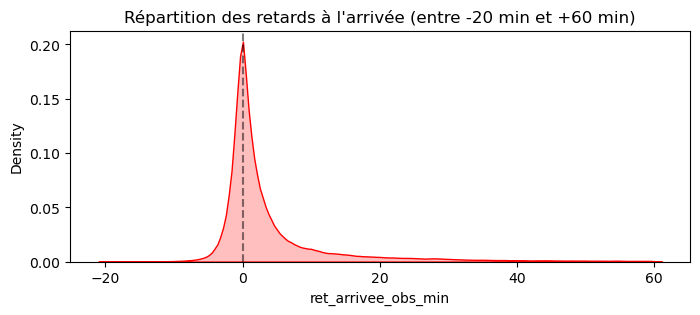

In [67]:
# répartition des retards à l'arrivée
plt.figure(figsize=(8,3))
sns.kdeplot(df_retards[(df_retards['ret_arrivee_obs_min'] >= -20) & (df_retards['ret_arrivee_obs_min'] <= 60)]['ret_arrivee_obs_min'], fill=True, bw_adjust=0.5, color='r')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.title("Répartition des retards à l'arrivée (entre -20 min et +60 min)")

<Axes: xlabel='ret_arrivee_obs_cat', ylabel='Count'>

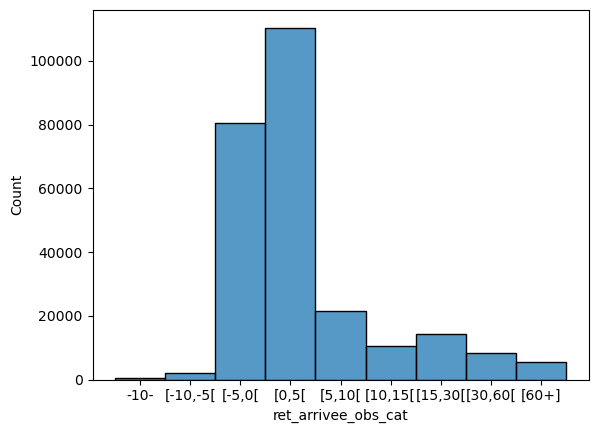

In [68]:
# histogramme des ret_cat
sns.histplot(data=df_retards, x="ret_arrivee_obs_cat", stat="count")


<Axes: xlabel='ret_arrivee_obs_cat', ylabel='Count'>

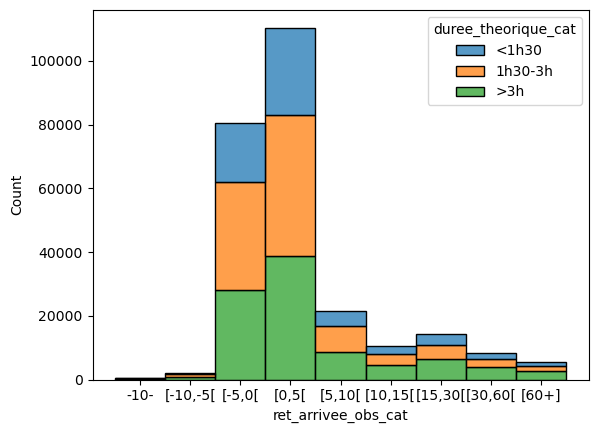

In [69]:
# histogramme empilé des retards par catégorie, coloré selon la catégorie de durée du trajet
sns.histplot(data=df_retards, x="ret_arrivee_obs_cat", hue="duree_theorique_cat", multiple="stack", stat="count")

In [71]:
df_retards.head()

,id_circ,date_circ,num_marche,code_ci_origine,lib_ci_origine,code_ci_destination,lib_ci_destination,lib_ui,lib_tct_depart,lib_tct_arrivee,id_engin_depart,id_engin_arrivee,depart_theorique,depart_observe,depart_estime,arrivee_theorique,arrivee_observe,arrivee_estime,distance_totale,ret_depart_obs_sec,ret_depart_obs_min,ret_arrivee_obs_sec,ret_arrivee_obs_min,ret_arrivee_obs_cat,duree_theorique_min,duree_theorique_cat,duree_observee_min,mois,jour_semaine,heure_depart,heure_arrivee
0,82518798,2024-01-01,2352,182014,Colmar,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGV2N2,TGV2N2,2024-01-01 07:41:00,2024-01-01 07:41:26,2024-01-01 07:41:26,2024-01-01 08:16:00,2024-01-01 08:15:14,2024-01-01 08:15:14,65817,26.00,0.43,-46.00,-0.77,"[-5,0[",35.00,<1h30,33.80,1,0,7,8
1,82518819,2024-01-01,2407,113001,Paris-Est,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 07:58:00,2024-01-01 07:58:06,2024-01-01 07:58:06,2024-01-01 09:59:00,2024-01-01 09:58:40,2024-01-01 09:58:40,439423,6.00,0.10,-20.00,-0.33,"[-5,0[",121.00,1h30-3h,120.57,1,0,7,9
2,82518825,2024-01-01,2535,141002,Nancy-Ville,113001,Paris-Est,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:11:00,2024-01-01 08:11:01,2024-01-01 08:11:01,2024-01-01 09:48:30,2024-01-01 09:48:23,2024-01-01 09:48:23,327284,1.00,0.02,-7.00,-0.12,"[-5,0[",97.50,1h30-3h,97.37,1,0,8,9
3,82518833,2024-01-01,2587,113001,Paris-Est,212027,Strasbourg-Ville,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 09:11:00,2024-01-01 09:10:42,2024-01-01 09:10:42,2024-01-01 12:17:00,2024-01-01 12:16:22,2024-01-01 12:16:22,476829,-18.00,-0.30,-38.00,-0.63,"[-5,0[",186.00,>3h,185.67,1,0,9,12
5,82518845,2024-01-01,2715,113001,Paris-Est,172007,Charleville-Mézières,SNCF-VOYAGES,"TAGV - Est, à charge","TAGV - Est, à charge",TGVR,TGVR,2024-01-01 08:28:00,2024-01-01 08:27:58,2024-01-01 08:27:58,2024-01-01 10:10:30,2024-01-01 10:08:30,2024-01-01 10:08:30,233841,-2.00,-0.03,-120.00,-2.00,"[-5,0[",102.50,1h30-3h,100.53,1,0,8,10


In [103]:
# Taux de retard à l'arrivée au seuil de 5 minutes, par heure_arrivee
taux_retard_arrivee = pd.DataFrame({
    'heure_arrivee': np.arange(0, 24),
    'heure_arrivee_str': np.arange(0, 24).astype(str),
    'nb_trains' : df_retards.groupby('heure_arrivee').size().tolist(),
    'nb_retards' : df_retards[df_retards['ret_arrivee_obs_min'] > 5].groupby('heure_arrivee').size().tolist()
})

taux_retard_arrivee['taux_retard'] = taux_retard_arrivee['nb_retards'] / taux_retard_arrivee['nb_trains']

taux_retard_arrivee

,heure_arrivee,heure_arrivee_str,nb_trains,nb_retards,taux_retard
0,0,0,1798,955,0.53
1,1,1,280,218,0.78
2,2,2,62,55,0.89
3,3,3,36,36,1.00
4,4,4,14,14,1.00
5,5,5,60,7,0.12
6,6,6,439,25,0.06
7,7,7,4132,587,0.14
8,8,8,10928,1627,0.15
9,9,9,15873,3366,0.21


<Axes: xlabel='heure_arrivee_str', ylabel='taux_retard'>

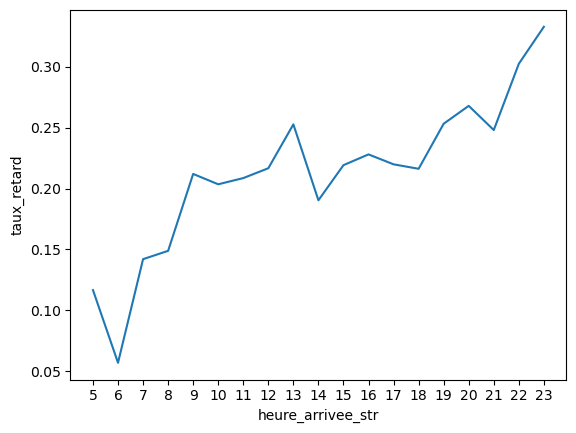

In [105]:
# Graphique du taux de retard à l'arrivée au seuil de 5 minutes, par heure_arrivee, après 5h
sns.lineplot(data=taux_retard_arrivee[taux_retard_arrivee['heure_arrivee'] >= 5], x='heure_arrivee_str', y='taux_retard')